# **Assignment No. 3**

*Submitted by:* Sarfraz Ahmad

*Registration No:* 363320

*Session:* MSDS-2021

*Submitted to:* Dr. Mozzam Faraz


## **Importing Libraries**

In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
import skimage
from skimage import io
from PIL import Image

import cv2
from xml.etree import ElementTree as et

import torch
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import time
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

import xml.etree.ElementTree as ET

import matplotlib.patches as patches

seed = 123
torch.manual_seed(seed)
from collections import Counter
%matplotlib inline

## **FasterRCNN**

### **Loading and Preparing Dataset**

In [3]:
class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)
   
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        img_res /= 255.0
        
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        wt = img.shape[1]
        ht = img.shape[0]
        
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# Create the image bounding boxes for objects in the images

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)
    
    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()
    
    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    
    plt.show()

### **Load Images from Directory**

In [5]:
train_dir = '/Users/sarfrazahmad/Documents/NUST/Semester 3/CV/Project/Fruits_Data_Set/train_zip/train'
test_dir = '/Users/sarfrazahmad/Documents/NUST/Semester 3/CV/Project/Fruits_Data_Set/test_zip/test'

dataset = FruitImagesDataset(train_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



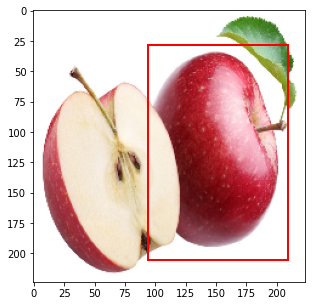

In [6]:
## Object detection using bounding box on Random Sample Image

img, target = dataset[np.random.randint(100)]
plot_img_bbox(img, target)

### **Data Augmentation**

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
# Data Augmentation
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.3),
            ToTensorV2(p=1.0) 
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
# Data Augmentation on Training and Test set
train_transform=get_transform(train=True)
test_transform=get_transform(train=False)

In [9]:
# Transform Training and Test set

dataset = FruitImagesDataset(train_dir, 224, 224, train_transform)
dataset_test = FruitImagesDataset(test_dir, 224, 224, test_transform)

torch.manual_seed(1)
np.random.seed(1)
indices = np.random.permutation(len(dataset)).tolist()

In [10]:
test_split = 0.1
tsize = len(dataset) - int(len(dataset)*test_split)

train_data = torch.utils.data.Subset(dataset, indices[:tsize])
val_data = torch.utils.data.Subset(dataset, indices[tsize:])

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

n_batches, n_batches_test = len(train_loader), len(test_loader)

{'boxes': tensor([[ 59.5200,  64.6400, 174.0800, 173.4400]]), 'labels': tensor([3]), 'area': tensor([12464.1279]), 'iscrowd': tensor([0]), 'image_id': tensor([183])}


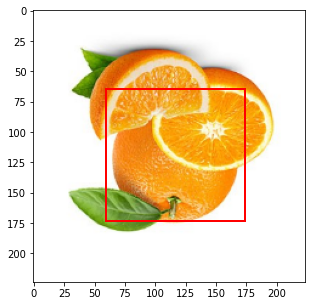

In [18]:
images, targets = next(iter(train_loader))
a = np.random.randint(5)
print(targets[a])
plot_img_bbox(images[a], targets[a])

### **Model and Parameter Initialization**

In [19]:
# Defind FasterRCNN Model
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_object_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### **Model Training**

In [21]:
metric = MeanAveragePrecision()

def train_model(model, data_loader=None, num_epoch=10):

    for epoch in range(1, num_epoch + 1):
        print(f"Starting epoch {epoch} of {num_epoch}")

        time_start = time.time()
        loss_accum = 0.0
        # loss_mask_accum = 0.0
        loss_classifier_accum = 0.0
        
        model.train()
        
        for batch_idx, (images, targets) in enumerate(data_loader, 1):

            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            # loss_mask = loss_dict['loss_mask'].item()
            loss_accum += loss.item()
            # loss_mask_accum += loss_mask
            loss_classifier_accum += loss_dict['loss_classifier'].item()

            if batch_idx % 500 == 0:
                print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}.")

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        # train_loss_mask = loss_mask_accum / n_batches
        train_loss_classifier = loss_classifier_accum / n_batches

        elapsed = time.time() - time_start

        torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        prefix = f"[Epoch {epoch:2d} / {num_epoch:2d}]"
        # print(prefix)
        # print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
        print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')
        
        preds_single = []
        targets_single = []
        
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            targets_single.extend(targets)
    
            model.eval()
            with torch.no_grad():
                pred = model(images)
            
            preds_single.extend(pred)
        
        metric.update(preds_single, targets_single)
        batch_map = metric.compute()
        
        print(f"Val mAP: {batch_map['map']}")
        
    return model

In [22]:
num_epoch = 30
model = train_model(model, train_loader, num_epoch)

Starting epoch 1 of 30
[Epoch  1 / 30] Train loss:   0.465 [30 secs] | Val mAP: 0.3410383462905884
Starting epoch 2 of 30
[Epoch  2 / 30] Train loss:   0.234 [24 secs] | Val mAP: 0.40421250462532043
Starting epoch 3 of 30
[Epoch  3 / 30] Train loss:   0.183 [24 secs] | Val mAP: 0.4152418375015259
Starting epoch 4 of 30
[Epoch  4 / 30] Train loss:   0.143 [24 secs] | Val mAP: 0.4576515257358551
Starting epoch 5 of 30
[Epoch  5 / 30] Train loss:   0.132 [24 secs] | Val mAP: 0.4816906154155731
Starting epoch 6 of 30
[Epoch  6 / 30] Train loss:   0.125 [24 secs] | Val mAP: 0.4966219961643219
Starting epoch 7 of 30
[Epoch  7 / 30] Train loss:   0.121 [24 secs] | Val mAP: 0.5091090202331543
Starting epoch 8 of 30
[Epoch  8 / 30] Train loss:   0.118 [24 secs] | Val mAP: 0.5193484425544739
Starting epoch 9 of 30
[Epoch  9 / 30] Train loss:   0.119 [24 secs] | Val mAP: 0.5266315340995789
Starting epoch 10 of 30
[Epoch 10 / 30] Train loss:   0.122 [25 secs] | Val mAP: 0.5331533551216125
Starting

### **Model Evaluation**

In [23]:
metric_test = MeanAveragePrecision()

preds_single = []
targets_single = []

for batch_idx, (images, targets) in enumerate(test_loader, 1):

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    targets_single.extend(targets)

    model.eval()
    with torch.no_grad():
        pred = model(images)

    preds_single.extend(pred)

metric_test.update(preds_single, targets_single)
test_map = metric.compute()

print(f"Test Mean Average Precision: {test_map['map']}")

Test Mean Average Precision: 0.5712881684303284


{'boxes': tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]]), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([0])}


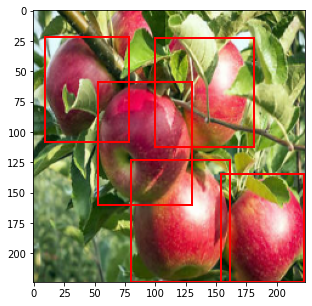

In [46]:
images, targets = next(iter(test_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])

In [47]:
import torchvision

def apply_threshold(prediction, threshold=0.6):
    index = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    pred = prediction.copy()
    pred['boxes'] = pred['boxes'][index]
    pred['scores'] = pred['scores'][index]
    pred['labels'] = pred['labels'][index]
    
    return pred


def apply_threshold_batch(prediction, threshold=0.1):
    preds = []

    for data in prediction:
        preds.append(apply_threshold(data, threshold))
        
    return preds

In [48]:
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([images[0].to(device)])

print(prediction)

[{'boxes': tensor([[8.3642e+01, 1.1842e+02, 1.6279e+02, 2.1819e+02],
        [5.2448e+01, 5.6044e+01, 1.3124e+02, 1.5758e+02],
        [1.5611e+02, 1.3827e+02, 2.2313e+02, 2.2151e+02],
        [7.0091e+00, 2.1504e+01, 7.3634e+01, 1.0523e+02],
        [1.1385e+02, 1.8338e+01, 1.8761e+02, 1.1976e+02],
        [6.4604e+01, 2.9095e-03, 1.0147e+02, 4.3762e+01],
        [5.6354e+01, 7.7824e+01, 1.4865e+02, 2.1048e+02],
        [3.8954e+01, 1.5580e+01, 1.6668e+02, 1.6450e+02],
        [1.1168e+02, 1.3370e+02, 1.9751e+02, 2.2058e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.9937, 0.9919, 0.9827, 0.9536, 0.8139, 0.3236, 0.0655, 0.0545],
       device='cuda:0')}]


[{'boxes': tensor([[8.3642e+01, 1.1842e+02, 1.6279e+02, 2.1819e+02],
        [1.5611e+02, 1.3827e+02, 2.2313e+02, 2.2151e+02],
        [7.0091e+00, 2.1504e+01, 7.3634e+01, 1.0523e+02],
        [1.1385e+02, 1.8338e+01, 1.8761e+02, 1.1976e+02],
        [6.4604e+01, 2.9095e-03, 1.0147e+02, 4.3762e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.9919, 0.9827, 0.9536, 0.8139], device='cuda:0')}]


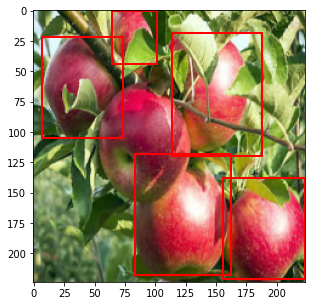

In [52]:
filtered_preds = apply_threshold_batch(prediction, threshold=0.1)
print(filtered_preds)
plot_img_bbox(images[0], filtered_preds[0])

## **YOLO**

### **Loading Dataset**

In [53]:
images = [image for image in sorted(os.listdir(train_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [54]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=train_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}
    
        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text
            img = Image.open(self.files_dir + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])

                
        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

### **Additional Functions**

In [55]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [56]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [57]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [58]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

### **YOLO Model Architecture**

In [59]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]

### **YOLO Model and Loss Definitions**

In [60]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == list:
                conv1 = x[0] #Tuple
                conv2 = x[1] #Tuple
                repeats = x[2] #Int
                
                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]
                    
        return nn.Sequential(*layers)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(nn.Flatten(), nn.Linear(1024 * S * S, 496), nn.Dropout(0.0), nn.LeakyReLU(0.1), nn.Linear(496, S * S * (C + B * 5)))#Original paper uses nn.Linear(1024 * S * S, 4096) not 496. Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13

In [61]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

### **Model Training**

In [62]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [63]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [64]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [65]:
def main():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=train_dir
    )

    test_dataset = FruitImagesDataset(
        transform=transform, 
        files_dir=test_dir
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        
        scheduler.step(mean_avg_prec)
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    
if __name__ == "__main__":
    main()

  7%|▋         | 1/15 [00:00<00:10,  1.28it/s, loss=1.48e+3]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 15/15 [00:09<00:00,  1.52it/s, loss=786]   


Mean loss was 696.7954060872396
Train mAP: 0.0


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, loss=421]


Mean loss was 349.09796651204425
Train mAP: 0.0


100%|██████████| 15/15 [00:07<00:00,  1.92it/s, loss=199]


Mean loss was 230.12286173502605
Train mAP: 0.012639995664358139


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, loss=171] 


Mean loss was 162.62015279134116
Train mAP: 0.029984787106513977


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=116] 


Mean loss was 123.6313690185547
Train mAP: 0.13313937187194824


100%|██████████| 15/15 [00:08<00:00,  1.80it/s, loss=116] 


Mean loss was 102.23619537353515
Train mAP: 0.24555383622646332


100%|██████████| 15/15 [00:08<00:00,  1.86it/s, loss=119] 


Mean loss was 92.07318064371745
Train mAP: 0.3039739429950714


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=85.2]


Mean loss was 81.22862294514974
Train mAP: 0.3756708800792694


100%|██████████| 15/15 [00:08<00:00,  1.83it/s, loss=57.7]


Mean loss was 72.38085428873698
Train mAP: 0.4398312568664551


100%|██████████| 15/15 [00:08<00:00,  1.79it/s, loss=84.1]


Mean loss was 65.91751658121744
Train mAP: 0.5183297991752625


100%|██████████| 15/15 [00:07<00:00,  1.91it/s, loss=72.3]


Mean loss was 61.69949849446615
Train mAP: 0.5583614110946655


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=48]  


Mean loss was 61.52363713582357
Train mAP: 0.6028931140899658


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=51.4]


Mean loss was 55.80756429036458
Train mAP: 0.6701981425285339


100%|██████████| 15/15 [00:07<00:00,  1.89it/s, loss=71.5]


Mean loss was 53.66619669596354
Train mAP: 0.7124722003936768


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, loss=61.9]


Mean loss was 50.08073933919271
Train mAP: 0.7548367381095886


100%|██████████| 15/15 [00:07<00:00,  1.90it/s, loss=36.7]


Mean loss was 47.30387229919434
Train mAP: 0.8160790801048279


100%|██████████| 15/15 [00:08<00:00,  1.87it/s, loss=39.2]


Mean loss was 45.51748174031575
Train mAP: 0.8460164666175842


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=43.1]


Mean loss was 44.71894912719726
Train mAP: 0.8544055819511414


100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=56.7]


Mean loss was 42.80793329874675
Train mAP: 0.8415204882621765


100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=38.8]


Mean loss was 41.37201436360677
Train mAP: 0.8799982070922852
=> Saving checkpoint


### **Model Evaluation**

In [66]:
LOAD_MODEL = True
EPOCHS = 1

In [67]:
def predictions():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    test_dataset = FruitImagesDataset(
        transform=transform, 
        df=test_df,
        files_dir=test_dir
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )
        
    for epoch in range(EPOCHS):
        model.eval()
        train_fn(test_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Test mAP: {mean_avg_prec}")


predictions()

=> Loading checkpoint


100%|██████████| 4/4 [00:02<00:00,  1.93it/s, loss=115]


Mean loss was 137.33978462219238
Test mAP: 0.17733323574066162
